# Interpolate the numerical accuracy threshold search results

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
#import re
#import datetime
#import shutil
import qsoconfig
import qsoresult

## Configuration

In [4]:
data_dir = "example_output"
result_subdir = "ising_chain-3q-nal"
#data_dir = "output/optim_CNOT"
#result_subdir = "nal"
param_file_pat = "params*.ini"
coll_file_pat = "nal_collate*.txt"
interp_fname = "interp.dat"
plot_fname = "interplot.png"
verbosity = 1



## Loading the result data

In [5]:
if '~' in data_dir:
    data_dir = os.path.expanduser(data_dir)
elif not os.path.abspath(data_dir):
    # Assume relative path from cwd given
    data_dir = os.path.join(os.getcwd(), data_dir)

res_dir = os.path.join(data_dir, result_subdir)

print("Results dir:\n{}".format(res_dir))
if not os.path.isdir(res_dir):
    raise RuntimeError("Results dir not valid")

# look for files to read existing results
coll_na = {}
na_list = []

if verbosity > 0:
    print("Searching in:\n{}".format(res_dir))
    print("Looking for collation file matching {}\n".format(coll_file_pat))
files = glob.glob(os.path.join(res_dir, coll_file_pat))

if len(files) == 0:
    print("No collation file to process")

plot_fpath = os.path.join(res_dir, plot_fname)

# Take the most recent file, assume last in list
collf = sorted(files)[-1]
if verbosity > 0:
    print("Loading collation from file:\n{}\n".format(collf))
reslist = qsoresult.MultiRepResult.load_from_txt(collf)
for na_res in reslist:
    na_list.append(na_res.numer_acc)
    coll_na[na_res.numer_acc] = na_res

na_arr = np.array(sorted(na_list))
succ_props = []
num_iters = []
for na in na_arr:
    na_res = coll_na[na]
    succ_props.append(float(na_res.num_primary_success) / na_res.num_res)
    num_iters.append(na_res.mean_iter_primary_success)
    fid_err_targ = na_res.fid_err_targ

succ_arr = np.array(succ_props)
iter_arr = np.array(num_iters)
na_lim = na_arr[-1]*1.2

# Look for previous interp results file
interp_fpath = os.path.join(res_dir, interp_fname)
if os.path.isfile(interp_fpath):
    if verbosity > 0:
        print("Loading interp params from:\n{}\n".format(interp_fpath))
    data = np.loadtxt(interp_fpath)
    # Note num_qubits only added to the file 2018-04-13
    # interp files from before that will need number of qubits inserting
    nq = int(data[0])
    na_lb = data[1]
    na_ub = data[2]
    try:
        succ_thresh = data[3]
    except:
        succ_thresh = 0.5
else:
    # No interp results file, look for a parameter file
    param_pat = os.path.join(res_dir, param_file_pat)
    if verbosity > 0:
        print("Looking for parameter file matching:\n{}".format(param_pat))
    files = glob.glob(param_pat)
    n_files = len(files)
    if n_files == 0:
        print("NO PARAMETER FILES FOUND!")
        raise RuntimeError("No parameter file")
    print("Loading configuration from:\n{}".format(files[0]))
    optim = qsoconfig.gen_config(files[0])
    dyn = optim.dynamics
    tc = optim.termination_conditions
    fid_comp = optim.dynamics.fid_computer
    nq = dyn.num_qubits
    if not fid_comp.numer_acc_exact:
        fid_comp.st_numer_acc = round_sigfigs(
                fid_comp.st_numer_acc*fid_err_targ/tc.fid_err_targ, 6)
        fid_comp.end_numer_acc = round_sigfigs(
                fid_comp.end_numer_acc*fid_err_targ/tc.fid_err_targ, 6)

    na_lb = fid_comp.st_numer_acc
    na_ub = fid_comp.end_numer_acc
    succ_thresh = 0.5



Results dir:
example_output/ising_chain-3q-nal
Searching in:
example_output/ising_chain-3q-nal
Looking for collation file matching nal_collate*.txt

Loading collation from file:
example_output/ising_chain-3q-nal/nal_collate_qso-pure_Choi_local-chain-Ising-XY-CNOT-nq3.j1496835.txt

Loading interp params from:
example_output/ising_chain-3q-nal/interp.dat



Numerical accuracy threshold calculated:
50.0% thresh=1.379e-03 +/- 1.05e-04

Mean interations and combined error for numerical accuracy threshold calculated:
na_thresh_iter=2.465e+01 +/- 3.25e-01

Numerical accuracy result bounds: lower 0.0003, upper 0.003


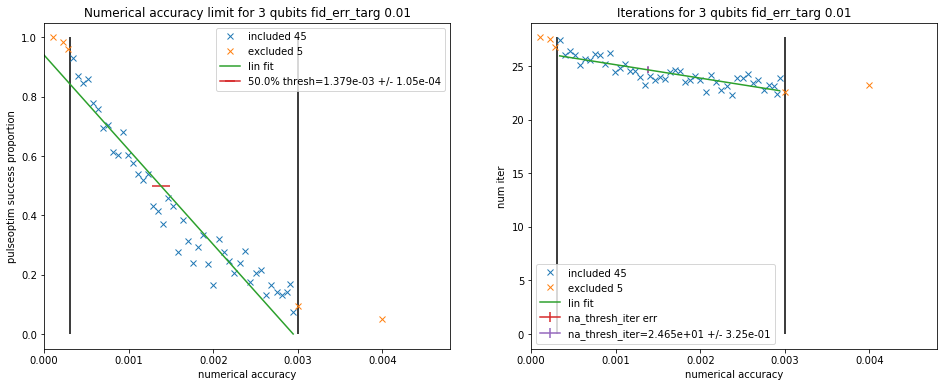

In [12]:
fig = plt.figure(figsize=(16,6))

sel = (na_arr > na_lb) & (na_arr < na_ub)
sel_na = na_arr[sel]
other_na = na_arr[~sel]
sel_succ = succ_arr[sel]
other_succ = succ_arr[~sel]
sel_iter = iter_arr[sel]
other_iter = iter_arr[~sel]

fig.clear()
ax1 = fig.add_subplot(121)
ax1.plot(sel_na, sel_succ, 'x', label='included {}'.format(len(sel_na)))
ax1.plot(other_na, other_succ, 'x', label='excluded {}'.format(len(other_na)))
ax1.vlines([na_lb, na_ub], 0, 1)
ax1.set_xlim(0, na_lim)
ax1.set_title("Numerical accuracy limit for {} "
             "qubits fid_err_targ {}".format(nq, fid_err_targ))
ax1.set_xlabel("numerical accuracy")
ax1.set_ylabel("pulseoptim success proportion")

ax2 = fig.add_subplot(122)
ax2.plot(sel_na, sel_iter, 'x', label='included {}'.format(len(sel_na)))
ax2.plot(other_na, other_iter, 'x', label='excluded {}'.format(len(other_na)))
ax2.vlines([na_lb, na_ub], 0, max(iter_arr))

ax2.set_xlim(0, na_lim)
ax2.set_title("Iterations for {} "
             "qubits fid_err_targ {}".format(nq, fid_err_targ))
ax2.set_xlabel("numerical accuracy")
ax2.set_ylabel("num iter")

num_sel = len(sel_na)
interp_data = [nq, na_lb, na_ub, succ_thresh, fid_err_targ, num_sel]

# Note we are doing this inverted,
# as we are interested in the error in na to succ_prop
# m, c, r, p, e = linregress(sel_succ, sel_na)
try:
    p, V = np.polyfit(sel_succ, sel_na, 1, cov=True)
    m = p[0]
    c = p[1]
    m_var = V[0][0]
    c_var = V[1][1]
    interpsp = True
except:
    print("success proportion polyfit failed: {}".format(sys.exc_info()[0]))
    print("Try changing the result bounds")
    interpsp = False

if interpsp:
    # plot the fit
    # Not this is simple only because range is succ=0 to succ=1
    fitlinex = [c, m + c]
    fitliney = [0, 1]
    na_thresh = succ_thresh*m + c
    na_thresh_err = np.sqrt(m_var*succ_thresh**2 + c_var)
    na_thresh_msg = '{}% thresh={:0.3e} +/- {:0.2e}'.format(
                        succ_thresh*100, na_thresh, na_thresh_err)
    print("Numerical accuracy threshold calculated:\n" + na_thresh_msg + "\n")

    interp_data += [na_thresh, na_thresh_err]
    ax1.plot(fitlinex, fitliney, label='lin fit')
    ax1.errorbar(na_thresh, succ_thresh, xerr=na_thresh_err, label=na_thresh_msg)
    ax1.legend()

    try:
        p, V = np.polyfit(sel_na, sel_iter, 1, cov=True)
        m = p[0]
        c = p[1]
        m_var = V[0][0]
        c_var = V[1][1]
        if verbosity > 1:
            print("interpni: m {}, c{}".format(m, c))
            print("interpni variance: m {}, c{}".format(m_var, c_var))
        interpni = True
    except:
        print("num iter polyfit failed: {}".format(sys.exc_info()[0]))
        interpni = False

    if interpni:
        # plot the fit
        miny = min(sel_iter)
        maxy = max(sel_iter)
        minx = min(sel_na)
        maxx = max(sel_na)
        fitlinex = [minx, maxx]
        fitliney = [m*minx + c, m*maxx + c]
        na_thresh_iter = na_thresh*m + c
        iter_err = np.sqrt(m_var*na_thresh**2 + c_var)
        comb_err = np.sqrt((m*na_thresh_err)**2 + iter_err**2)
        na_thresh_iter_msg ='na_thresh_iter={:0.3e} +/- {:0.2e}'.format(
                                na_thresh_iter, comb_err)
        print("Mean interations and combined error for numerical accuracy "
              "threshold calculated:\n" + na_thresh_iter_msg + "\n")
        
        interp_data += [na_thresh_iter, iter_err, comb_err]
        ax2.plot(fitlinex, fitliney, label='lin fit')
        ax2.errorbar(na_thresh, na_thresh_iter, yerr=iter_err, label='na_thresh_iter err')
        ax2.errorbar(na_thresh, na_thresh_iter, yerr=comb_err, label=na_thresh_iter_msg)
        ax2.legend(loc=0)

np.savetxt(interp_fpath, interp_data, fmt='%.5e')
print("Numerical accuracy result bounds: lower {}, upper {}".format(na_lb, na_ub))

In [9]:
# Here you can change the bounds for the reuslts that are included in the interpolation.
# (see previous output for current values)
# Then run the plotting cell again
# Lower (for example data 0.0001 was used)
na_lb = 0.0003
# Upper (for example data 0.002 was used)
na_ub = 0.003
# The 50% success threshold was used for the paper. Other options are also valid.
succ_thresh = 0.5